In [1]:
import random
import os
from collections import Counter, defaultdict
import sys

import pandas as pd
import numpy as np

In [2]:
%cd /Users/johannesbreit/Library/CloudStorage/OneDrive-UniversityCollegeLondon/COMP0087/project/nlpproject

/Users/johannesbreit/Library/CloudStorage/OneDrive-UniversityCollegeLondon/COMP0087/project/nlpproject


In [3]:
corpus_in = pd.read_csv('../nlpproject/nlp/data/example_inputs_pos_and_neg.tsv.gz', compression='gzip', header=0, sep='\t')

#Remove any \n from the rows 
corpus_in.replace("\n","",inplace=True)
corpus_in.replace('(\n)','',regex=True,inplace=True)

#Create sentences
df_data_sentences = corpus_in[['left', 'entity1', "middle",'entity2','right']].astype(str).agg(' '.join, axis=1)
corpus_in['sentences'] = df_data_sentences.values

corpus_in.head()

,entity1,entity2,left,middle,right,article,label,sentences
0,Apple Inc,Samsung Electronics Co Ltd,These reviews have been especially popular wit...,(AAPL.O) and,(005930.KS) frequently hit with patent infrin...,50b8f1a67bb7c2cab2fe56b55a24f59ad1703c07b7053e...,0,These reviews have been especially popular wit...
1,Bharti Airtel Ltd,Reliance Industries Ltd,* Q4 profit 829 mln rupees vs. 3.73 bln rupees...,posted its lowest quarterly profit in nearly ...,"Jio, the telecoms arm of Reliance, into India...",603eeb451da67a70850a823e4eb4e1221a5358040bde3b...,0,* Q4 profit 829 mln rupees vs. 3.73 bln rupees...
2,Reliance Industries Ltd,Bharti Airtel Ltd,"The entry of Reliance Jio, the telecoms arm of",", into India's telecoms sector has set off a b...",'s managing director and chief executive for I...,603eeb451da67a70850a823e4eb4e1221a5358040bde3b...,0,"The entry of Reliance Jio, the telecoms arm of..."
3,Bharti Airtel Ltd,Reliance Industries Ltd,The U.S. Supreme Court on Tuesday ruled that f...,dan-based Arab Bank Plc helped finance militan...,"24, 2016.",26cb6ec3607fdb028b712d260131058e9b01b9aadc26cf...,1,The U.S. Supreme Court on Tuesday ruled that f...
4,Reliance Industries Ltd,Bharti Airtel Ltd,REUTERS/Aziz Ta,PhotoThe 5-4 decision brought to an end a law...,minor connection between the terrorist attacks...,26cb6ec3607fdb028b712d260131058e9b01b9aadc26cf...,1,REUTERS/Aziz Ta Reliance Industries Ltd Photo...


In [4]:
kb_df = pd.read_csv('../nlpproject/nlp/data/example_kb_all_supplier.tsv.gz', compression='gzip', 
                                 names= ['relation', 'subject', 'object'], sep='\t', quotechar='"')

kb_df.head(2)                                

,relation,subject,object
0,supplier of,Apple Inc,Seoul Semiconductor Co Ltd
1,supplier of,Koizumi furnitech Thailand Co Ltd,Seoul Semiconductor Co Ltd


In [5]:
def corpus_density_based_split(corpus, kb, split_ratios = np.array([0.6,0.2,0.2]), verbose = True):
    corp = corpus.copy()
    _kb = kb.copy()

    # Create an alphabetically sorted (E1, E2) tuple column of the two entities mentioned in each row
    corp['relation_tuple'] = [tuple(sorted([E1, E2])) for E1, E2 in zip(corp.entity1, corp.entity2)]       
    
    # Create a df which contains the number of entries per unique E1,E2 pair in corpus and sort in descending order
    corpus_counts = corp.groupby(['relation_tuple']).agg('size').reset_index().sort_values(by = 0, ascending=False).rename(columns = {0: 'sentence_counts'})

    _counts_per_split = corpus_counts.sentence_counts.sum() * split_ratios
    _counts_cumsum = _counts_per_split.cumsum()
    print('Aim to have approx {} entries per train/dev/test split, respectively.\n' .format(_counts_per_split))

    # Shuffle this to get rid of numerical order 
    shuffled_corpus_counts = corpus_counts.sample(frac=1, random_state = 42) # Perhaps we can also find deterministic "shuffle"

    # Now add column which gives cumulative counts of sentences down Pairs
    shuffled_corpus_counts['sentence_cumsum'] = np.cumsum(shuffled_corpus_counts.sentence_counts)

    def assign_splits(corpus_counts, counts_cumsum):
        splits = []
        for scs in corpus_counts.sentence_cumsum:
            if scs <= counts_cumsum[0]: splits.append(0)
            elif scs > counts_cumsum[0] and scs <= counts_cumsum[1]: splits.append(1)
            else: splits.append(2)
        return splits

    shuffled_corpus_counts['split'] = assign_splits(shuffled_corpus_counts, _counts_cumsum)

    corp = corp.merge(shuffled_corpus_counts, how = 'left', on = 'relation_tuple')

    # Now merge corpus-based created splits onto KB 
    # MANY KB ENTRIES WILL NOT HAVE MATCHES 
    _kb['relation_tuple'] = [tuple(sorted([E1, E2])) for E1, E2 in zip(_kb.subject.astype(str), _kb.object.astype(str))]

    _kb = _kb.merge(corp[['relation_tuple', 'split']], how = 'left', on = 'relation_tuple')

    if verbose:
        corp_vals = corp.split.value_counts(normalize = False)
        corp_ratios = round(corp.split.value_counts(normalize = True),3)
        corp_balance = round(corp.groupby('split').agg('mean')['label'],2)

        kb_vals = _kb.fillna(99).split.value_counts(normalize = False)
        kb_ratios = round(_kb.fillna(99).split.value_counts(normalize = True),3)

        print('Corpus split:')
        print('Train: {} ({}%) \nDev: {} ({}%)\nTest: {} ({}%) \n' .format(corp_vals[0], corp_ratios[0], corp_vals[1], corp_ratios[1], corp_vals[2], corp_ratios[2]))

        print('Class Balance (positive class):')
        print('Train: {}%\nDev: {}%\nTest: {}% \n' .format(corp_balance[0], corp_balance[1], corp_balance[2]) )

        print('KB split:')
        print('Train: {} ({}%)\nDev: {} ({}%)\nTest: {} ({}%)' .format(kb_vals[0], kb_ratios[0], kb_vals[1], kb_ratios[1], kb_vals[2], kb_ratios[2]))
        print('Total of {} (E1,E2) ordered pairs in KB not assigned. \n' .format(kb_vals[99]))
    
    return corp, _kb

In [6]:
corp_out, kb_out = corpus_density_based_split(corpus_in, kb_df)

Aim to have approx [51778.8 17259.6 17259.6] entries per train/dev/test split, respectively.

Corpus split:
Train: 51555 (0.597%) 
Dev: 17339 (0.201%)
Test: 17404 (0.202%) 

Class Balance (positive class):
Train: 0.57%
Dev: 0.56%
Test: 0.65% 

KB split:
Train: 38941 (0.464%)
Dev: 11510 (0.137%)
Test: 16994 (0.203%)
Total of 16455 (E1,E2) ordered pairs in KB not assigned. 



In [7]:
corp_out

,entity1,entity2,left,middle,right,article,label,sentences,relation_tuple,sentence_counts,sentence_cumsum,split
0,Apple Inc,Samsung Electronics Co Ltd,These reviews have been especially popular wit...,(AAPL.O) and,(005930.KS) frequently hit with patent infrin...,50b8f1a67bb7c2cab2fe56b55a24f59ad1703c07b7053e...,0,These reviews have been especially popular wit...,"(Apple Inc, Samsung Electronics Co Ltd)",2962,39367,0
1,Bharti Airtel Ltd,Reliance Industries Ltd,* Q4 profit 829 mln rupees vs. 3.73 bln rupees...,posted its lowest quarterly profit in nearly ...,"Jio, the telecoms arm of Reliance, into India...",603eeb451da67a70850a823e4eb4e1221a5358040bde3b...,0,* Q4 profit 829 mln rupees vs. 3.73 bln rupees...,"(Bharti Airtel Ltd, Reliance Industries Ltd)",36,21306,0
2,Reliance Industries Ltd,Bharti Airtel Ltd,"The entry of Reliance Jio, the telecoms arm of",", into India's telecoms sector has set off a b...",'s managing director and chief executive for I...,603eeb451da67a70850a823e4eb4e1221a5358040bde3b...,0,"The entry of Reliance Jio, the telecoms arm of...","(Bharti Airtel Ltd, Reliance Industries Ltd)",36,21306,0
3,Bharti Airtel Ltd,Reliance Industries Ltd,The U.S. Supreme Court on Tuesday ruled that f...,dan-based Arab Bank Plc helped finance militan...,"24, 2016.",26cb6ec3607fdb028b712d260131058e9b01b9aadc26cf...,1,The U.S. Supreme Court on Tuesday ruled that f...,"(Bharti Airtel Ltd, Reliance Industries Ltd)",36,21306,0
4,Reliance Industries Ltd,Bharti Airtel Ltd,REUTERS/Aziz Ta,PhotoThe 5-4 decision brought to an end a law...,minor connection between the terrorist attacks...,26cb6ec3607fdb028b712d260131058e9b01b9aadc26cf...,1,REUTERS/Aziz Ta Reliance Industries Ltd Photo...,"(Bharti Airtel Ltd, Reliance Industries Ltd)",36,21306,0
...,...,...,...,...,...,...,...,...,...,...,...,...
86293,Microsoft Corp,Amazon.com Inc,The showing is a chance for Google and,", which have been bit players in a VOD market ...","(AMZN.O) and cable and satellite operators, t...",5ebe8ed41ddfb003b44e24135a68a3583f4871a7f9f2fb...,0,The showing is a chance for Google and Micros...,"(Amazon.com Inc, Microsoft Corp)",1093,35525,0
86294,Microsoft Corp,Apple Inc,The showing is a chance for Google and,", which have been bit players in a VOD market ...","(AAPL.O), Amazon (AMZN.O) and cable and satel...",5ebe8ed41ddfb003b44e24135a68a3583f4871a7f9f2fb...,1,The showing is a chance for Google and Micros...,"(Apple Inc, Microsoft Corp)",2052,66753,1
86295,Snap Inc,Twitter Inc,By Tim Baysinger Feb 8 Snap's,chat lags far behind rival social media outlet...,"in reaching older users, but the soon-to-be p...",ec4fad75485dc2fea9290bc86fc9e4c22e48901b547ad7...,0,By Tim Baysinger Feb 8 Snap's Snap Inc chat l...,"(Snap Inc, Twitter Inc)",83,4813,0
86296,Twitter Inc,Snap Inc,By Tim Baysinger Feb 8 Snap's Snapchat lags fa...,"in reaching older users, but the soon-to-be p...",prepares for its planned stock market debut i...,ec4fad75485dc2fea9290bc86fc9e4c22e48901b547ad7...,0,By Tim Baysinger Feb 8 Snap's Snapchat lags fa...,"(Snap Inc, Twitter Inc)",83,4813,0


In [8]:
kb_out.split.value_counts(dropna =False)

0.0    38941
2.0    16994
NaN    16455
1.0    11510
Name: split, dtype: int64

In [9]:
kb_out

,relation,subject,object,relation_tuple,split
0,supplier of,Apple Inc,Seoul Semiconductor Co Ltd,"(Apple Inc, Seoul Semiconductor Co Ltd)",NaN
1,supplier of,Koizumi furnitech Thailand Co Ltd,Seoul Semiconductor Co Ltd,"(Koizumi furnitech Thailand Co Ltd, Seoul Semi...",NaN
2,supplier of,Amazon.com Inc,DS Smith PLC,"(Amazon.com Inc, DS Smith PLC)",NaN
3,supplier of,Procter & Gamble Co,DS Smith PLC,"(DS Smith PLC, Procter & Gamble Co)",NaN
4,supplier of,Zymeworks Inc,DS Smith PLC,"(DS Smith PLC, Zymeworks Inc)",NaN
...,...,...,...,...,...
83895,supplier of,Cisco Systems Inc (Pre-Merger),Synetrix (Holdings) Ltd,"(Cisco Systems Inc (Pre-Merger), Synetrix (Hol...",NaN
83896,supplier of,Cisco Systems Inc (Pre-Merger),Servcorp Ltd,"(Cisco Systems Inc (Pre-Merger), Servcorp Ltd)",NaN
83897,supplier of,Cisco Systems Inc (Pre-Merger),SolarWinds Corp,"(Cisco Systems Inc (Pre-Merger), SolarWinds Corp)",NaN
83898,supplier of,Cisco Systems Inc (Pre-Merger),Unified Communications Ltd,"(Cisco Systems Inc (Pre-Merger), Unified Commu...",NaN


In [12]:
kb_out[kb_out.subject=='Apple Inc']

,relation,subject,object,relation_tuple,split
0,supplier of,Apple Inc,Seoul Semiconductor Co Ltd,"(Apple Inc, Seoul Semiconductor Co Ltd)",NaN
158,supplier of,Apple Inc,TDK Corp,"(Apple Inc, TDK Corp)",2.0
159,supplier of,Apple Inc,TDK Corp,"(Apple Inc, TDK Corp)",2.0
160,supplier of,Apple Inc,TDK Corp,"(Apple Inc, TDK Corp)",2.0
161,supplier of,Apple Inc,TDK Corp,"(Apple Inc, TDK Corp)",2.0
...,...,...,...,...,...
78457,supplier of,Apple Inc,Samsung Group,"(Apple Inc, Samsung Group)",0.0
78458,supplier of,Apple Inc,Global Unichip Corp,"(Apple Inc, Global Unichip Corp)",NaN
78459,supplier of,Apple Inc,Electronic Arts Inc,"(Apple Inc, Electronic Arts Inc)",0.0
78460,supplier of,Apple Inc,Pelephone Communications Ltd,"(Apple Inc, Pelephone Communications Ltd)",NaN


## Overlap Analysis

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
## Check for overlap between train/dev/test sets
# 1st test: Pair analysis: Check (E1, E2) in training pairs which appear in mulitple splits
training_split = corp_out[corp_out.split == 0]
val_split = corp_out[corp_out.split == 1]
test_split = corp_out[corp_out.split == 2]
training_pairs = training_split.relation_tuple.unique()

val_pair_tracker = {}
for pair in training_pairs:
    val_occurence = len(val_split[val_split.relation_tuple == pair])
    val_pair_tracker[pair] = val_occurence 

test_pair_tracker = {}
for pair in  val_split.relation_tuple.unique():
    test_occurence = len(test_split[test_split.relation_tuple == pair])
    test_pair_tracker[pair] = test_occurence 

In [14]:
pd.Series(val_pair_tracker.values()).unique(), pd.Series(test_pair_tracker.values()).unique()

(array([0]), array([0]))

No (E1, E2) pairs which exist in training set occur in val or test set.

### 1) Train - Validation

In [34]:
# Next want to check which single Entities which occur in the training set are also E1s or E2s in the validation and/or test sets

# Get Series of all unique E1s and E2s in training set
training_entities = pd.DataFrame(pd.Series(list(training_split.entity1.unique()) + list(training_split.entity2.unique())).unique()).rename(columns = {0: 'entity'})
print('{} unique entities in training set.' .format(len(training_entities)))
# Get Series of all unique E1s and E2s in validation set
val_ent_occurences = pd.DataFrame(pd.Series(list(val_split.entity1) + list(val_split.entity2)).value_counts()).reset_index().rename(columns = {'index': 'entity', 0: 'occ'})

# left join validation set entities with counts on the training set entities to see how often they occur in validation set
train_val_overlap = training_entities.merge(val_ent_occurences, how = 'left', on = 'entity').fillna(0)
train_val_overlap.sort_values(by = 'occ', ascending = False, inplace = True)

647 unique entities in training set.


In [35]:
print('Total size of val corpus: {}' .format(len(val_split)))
train_val_overlap.reset_index(drop=True).T

Total size of val corpus: 17339


,0,1,2,3,4,5,6,7,8,9,...,637,638,639,640,641,642,643,644,645,646
entity,Apple Inc,Amazon.com Inc,Microsoft Corp,Intel Corp,Boeing Co,Alphabet Inc,Lockheed Martin Corp,Toyota Motor Corp,Sharp Corp,Qualcomm Inc,...,Cray Inc,Telia Company AB,Qualtrics International Inc,Marketo Inc,TotalEnergies SE,TomTom NV,Oath Inc,Mitsubishi Electric Corp,Cargojet Inc,Eutelsat Communications SA
occ,7241.0,2966.0,2890.0,1550.0,1337.0,1055.0,811.0,773.0,749.0,712.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
train_val_overlap.occ.sum()

34626.0

^^ The number above is 2x the number of examples in the val set so 2 entities x len(val_set) <br>
So it seems like there is not a single entry in the validation split which does not contain an entity mentioned at least once in the training set...

In [36]:
training_split[training_split.relation_tuple.astype(str).str.contains('Apple')].head(2)

,entity1,entity2,left,middle,right,article,label,sentences,relation_tuple,sentence_counts,sentence_cumsum,split
0,Apple Inc,Samsung Electronics Co Ltd,These reviews have been especially popular wit...,(AAPL.O) and,(005930.KS) frequently hit with patent infrin...,50b8f1a67bb7c2cab2fe56b55a24f59ad1703c07b7053e...,0,These reviews have been especially popular wit...,"(Apple Inc, Samsung Electronics Co Ltd)",2962,39367,0
26,Apple Inc,Netflix Inc,,shares lost {AAPL.O;-PCTCHNG:2} percent as wo...,", also weighed on the Nasdaq.",90ce5e433c2f36e596ecc077cc8d101da1e52fbbfe8f60...,0,Apple Inc shares lost {AAPL.O;-PCTCHNG:2} pe...,"(Apple Inc, Netflix Inc)",455,1108,0


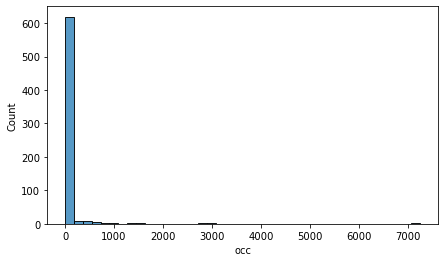

In [42]:
plt.subplots(figsize=(7,4))
sns.histplot(train_val_overlap.occ, bins  = 40)
plt.show()

In [39]:
train_val_overlap = train_val_overlap.reset_index(drop=True)

In [54]:
for i in range(15):
    df = train_val_overlap[train_val_overlap.occ == i]
    print('There are {} entities which overlap {} times in train-val sets' .format(len(df.occ), i))

There are 262 entities which overlap 0 times in train-val sets
There are 62 entities which overlap 1 times in train-val sets
There are 49 entities which overlap 2 times in train-val sets
There are 22 entities which overlap 3 times in train-val sets
There are 23 entities which overlap 4 times in train-val sets
There are 13 entities which overlap 5 times in train-val sets
There are 10 entities which overlap 6 times in train-val sets
There are 10 entities which overlap 7 times in train-val sets
There are 10 entities which overlap 8 times in train-val sets
There are 6 entities which overlap 9 times in train-val sets
There are 6 entities which overlap 10 times in train-val sets
There are 8 entities which overlap 11 times in train-val sets
There are 10 entities which overlap 12 times in train-val sets
There are 4 entities which overlap 13 times in train-val sets
There are 6 entities which overlap 14 times in train-val sets


In [79]:
cumsum_df = pd.DataFrame(train_val_overlap.occ.value_counts()).reset_index().sort_values(by='index')
cumsum_df['cumsum_occ'] = np.cumsum(cumsum_df.occ)  / len(training_entities)
cumsum_df.reset_index(drop=True, inplace=True)

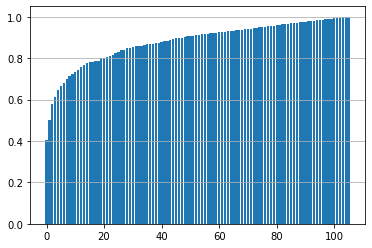

In [83]:
plt.bar(x = cumsum_df.index, height =cumsum_df.cumsum_occ)
plt.grid(which = 'major', axis = 'y')
plt.show()

In [78]:
cumsum_df

,index,occ,cumsum_occ
0,0.0,262,0.404946
1,1.0,62,0.500773
2,2.0,49,0.576507
4,3.0,22,0.610510
3,4.0,23,0.646059
...,...,...,...
77,1337.0,1,0.993818
78,1550.0,1,0.995363
79,2890.0,1,0.996909
84,2966.0,1,0.998454


### 1) Train - Test

In [86]:
# Get Series of all unique E1s and E2s in test set
test_ent_occurences = pd.DataFrame(pd.Series(list(test_split.entity1) + list(test_split.entity2)).value_counts()).reset_index().rename(columns = {'index': 'entity', 0: 'occ'})

# left join test set entities with counts on the test set entities to see how often they occur in test set
train_test_overlap = training_entities.merge(test_ent_occurences, how = 'left', on = 'entity').fillna(0)
train_test_overlap.sort_values(by = 'occ', ascending = False, inplace = True)

print('Total size of test corpus: {}' .format(len(test_split)))
train_test_overlap.reset_index(drop=True).T

Total size of test corpus: 17404


,0,1,2,3,4,5,6,7,8,9,...,637,638,639,640,641,642,643,644,645,646
entity,Apple Inc,General Motors Co,Boeing Co,Ford Motor Co,Qualcomm Inc,T-Mobile US Inc,AT&T Inc,Sprint Corp,Verizon Communications Inc,Amazon.com Inc,...,Westinghouse Air Brake Technologies Corp,Opower Inc,Veoneer Inc,Digia Oyj,Golar LNG Ltd,Beyond Meat Inc,Intersil Corp,Maxar Technologies Inc,Aveos Fleet Performance Inc,Eutelsat Communications SA
occ,2525.0,2024.0,1923.0,1821.0,1694.0,1566.0,1353.0,1250.0,1243.0,896.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


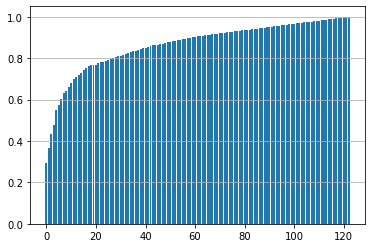

,0,1,2,3,4,5,6,7,8,9,...,113,114,115,116,117,118,119,120,121,122
index,0.000000,1.00000,2.000000,3.000000,4.000000,5.00000,6.000000,7.000000,8.000000,9.000000,...,896.00000,1243.000000,1250.000000,1353.000000,1566.000000,1694.000000,1821.000000,1923.000000,2024.000000,2525.0
occ,191.000000,45.00000,45.000000,29.000000,46.000000,14.00000,19.000000,21.000000,6.000000,12.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
cumsum_occ,0.295209,0.36476,0.434312,0.479134,0.550232,0.57187,0.601236,0.633694,0.642968,0.661515,...,0.98609,0.987635,0.989181,0.990726,0.992272,0.993818,0.995363,0.996909,0.998454,1.0


In [87]:
train_test_overlap = train_test_overlap.reset_index(drop=True)

cumsum_df = pd.DataFrame(train_test_overlap.occ.value_counts()).reset_index().sort_values(by='index')
cumsum_df['cumsum_occ'] = np.cumsum(cumsum_df.occ)  / len(training_entities)
cumsum_df.reset_index(drop=True, inplace=True)

plt.bar(x = cumsum_df.index, height =cumsum_df.cumsum_occ)
plt.grid(which = 'major', axis = 'y')
plt.show()

cumsum_df.T